# Grover's Algorithm qBraid Challenge

In this challenge you and your team are tasked to code Grover's Algorithm to find a valid Hamiltonian cycle in a graph with 5 vertices. A Hamiltonian cycle or circuit is a closed loop on a graph where the edges visits each node exactly once and travels back to the first node. You'll have to figure out how to setup a proper phase oracle which searches through the different paths and returns the unique Hamiltonian cycles in the circuit.

Before you get started make sure that:

- You've enabled your qBraid Amazon Braket account. `qbraid enable account aws_braket`
- Activated the Braket environment and are using the Braket Python 3 kernel (on the top right you should see **Python 3 [Braket]**)
- *Please copy this file and rename it <team_name>\_grover.ipynb*- we'd like to avoid merge conflicts with other submissions!

## Submission Checklist
- Make sure to include a readme!
- Make sure you've run or queued your solution on a real quantum computer (Rigetti M-1 perferred)
- Double check that your solution works with the autograder!

## Judging Criteria
- Your code must include a README.md which describes your implementation and includes how to run your solution.
- Your code should be documented and easy to understand!
- There are plenty of implementations on the web to guide you in better understanding Grover's search. Feel free to use them as guidance, but do code your solutions with as few out of box solutions 
    ie don't `from some_package import Grover`
- Your code must run a job on real hardware or SV1 simulator using the qBraid Amazon Braket Account.


## Challenge description
- The graph is undirected and constrained to 5 nodes and 8 vertices. This implies that you should get more than one possible Hamiltonian cycle. You will just need to verify one of them.
- There are no self loops
- It does not have to be the shortest path.
- You are free to choose any appropriate starting node.

Your results should be a list of integers which indicate the nodes which are traversed in the path which your Grover's Algorithm has found.

To use with the auto grader make sure that you provide it a list of integers:
[ initial_node, second_node, ... intial_node]

ex: [1,3,4,0,2,1]

Possible extensions:
- Generalize the oracle to handle smaller graphs where it verifies if there indeed exists a Hamiltonian cycle.
- Run on different Amazon Braket devices and check your results!
- Apply this algorithm to a cool real world scenario and discuss how it can be applied in the README.md.
- Anything else you and your team come up with!



### The graph
The graph is an undirected graph with 5 nodes and 8 edges.
You'll have to consider how to encode the edges as well as construct the correct oracle for the Grover's algorithm.

You're more than welcome to reference the Braket [**Grover's Algorithm tutorial**](../../amazon_braket_examples/advanced_circuits_algorithms/Grover/Grover.ipynb) as well as any other resources you find useful.


In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask

In [2]:
graph = nx.Graph()
graph.add_nodes_from([0,1,2,3,4])
graph.add_edges_from([(0, 4), (0, 3), (0, 2), (1, 2), (1, 4), (1, 3), (2, 4), (3, 4)])

After creating the random graph to get you started, we recreate it and save it as an object for you to work with.

Graph with 5 nodes and 8 edges
[(0, 4), (0, 3), (0, 2), (1, 2), (1, 4), (1, 3), (2, 4), (3, 4)]


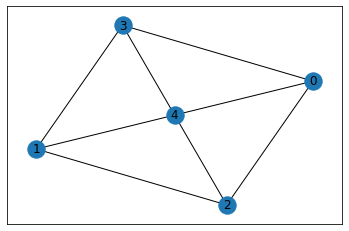

In [3]:
print(graph)
print(graph.edges)
nx.draw_networkx(graph)

## Run on a quantum device
We'd recommend double checking your implementation on a local simulator before running it on the Aspen M-1.


In [4]:
# Helper function to build C-C-Z gate
@circuit.subroutine(register=True)
def ccz(targets=[0, 1, 2]):
    """
    implementation of three-qubit gate CCZ
    """
    # define three-qubit CCZ gate
    ccz_gate = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0]],
                       dtype=complex)
    
    # instantiate circuit object
    circ = Circuit()
    
    # add CCZ gate
    circ.unitary(matrix=ccz_gate, targets=targets)
    
    return circ


# helper function for initialization
def initialize(n_qubits=3):
    """
    function to apply hadamard to all qubits
    """
    # Initialize with superposition
    circ = Circuit();
    circ.h(np.arange(n_qubits))
    
    return circ


# helper function for phase oracle
def oracle():
    """
    function to apply oracle for given target item
    """
    # instantiate circuit object
    circ = Circuit()
    
    for i in range(3):
        circ.cnot(2*i, 2*i+2)
        circ.cnot(2*i+1, 2*i+3)
        circ.x(2*i+2)
        circ.ccnot(2*i+2, 2*i+3, 8+i)
        circ.x(2*i+2)
        circ.cnot(2*i+1, 2*i+3)
        circ.cnot(2*i, 2*i+2)
        
    circ.ccz([8, 9, 10])
    
    for i in range(3):
        circ.cnot(2*i, 2*i+2)
        circ.cnot(2*i+1, 2*i+3)
        circ.x(2*i+2)
        circ.ccnot(2*i+2, 2*i+3, 8+i)
        circ.x(2*i+2)
        circ.cnot(2*i+1, 2*i+3)
        circ.cnot(2*i, 2*i+2)
    
    return circ


# helper function for amplification
def amplify(n_qubits=3):
    """
    function for amplitude amplification
    """
    # instantiate circuit object
    circ = Circuit()
    
    # Amplification
    circ.h(range(n_qubits))
    if n_qubits == 1:
        circ.z(0)
    elif n_qubits == 2:
        circ.x([0,1]).cz(0,1).x([0,1])
    elif n_qubits == 3:
        circ.x([0,1,2]).ccz([0,1,2]).x([0,1,2])
    else:
        circ.x(range(n_qubits))
        circ.ccnot(0,1,n_qubits)
        for i in range(n_qubits-4):
            circ.ccnot(i+2, n_qubits+i, n_qubits+i+1)
        circ.ccz([n_qubits-2, n_qubits-1, 2*n_qubits-4])
        for i in reversed(range(n_qubits-4)):
            circ.ccnot(i+2, n_qubits+i, n_qubits+i+1)
        circ.ccnot(0,1,n_qubits)
        circ.x(range(n_qubits))
    circ.h(range(n_qubits))
    
    return circ


# helper function for grover algorithm
def grover(n_qubits=8, n_reps=1):
    """
    function to put together individual modules of Grover algorithm
    """
    # initialize
    grover_circ = initialize(n_qubits)
    # oracle and amplify
    for ii in range(n_reps):
        # get oracle
        grover_circ.add(oracle())
        # amplify
        grover_circ.add(amplify(n_qubits))
    
    return grover_circ

In [17]:
# Function to run quantum task, check the status thereof, and collect results
def get_result(circ, n_qubits):

    # specify desired results_types
    circ.probability(target=range(n_qubits))

    # submit task: define task (asynchronous)
    task = device.run(circ, shots=1000)

    # Get ID of submitted task
    task_id = task.id
#     print('Task ID :', task_id)

    # Wait for job to complete
    status_list = []
    status = task.state()
    status_list += [status]
    print('Status:', status)

    # Only notify the user when there's a status change
    while status != 'COMPLETED':
        status = task.state()
        if status != status_list[-1]:
            print('Status:', status)
        status_list += [status]

    # get result
    result = task.result()

    # get metadata
    metadata = result.task_metadata

    # get output probabilities
    probs_values = result.values[0]

    # get measurement results
    measurement_counts = result.measurement_counts

    # print measurement results
    # print('measurement_counts:', measurement_counts)

    # bitstrings
    format_bitstring = '{0:0' + str(n_qubits) + 'b}'
    bitstring_keys = [format_bitstring.format(ii) for ii in range(2**n_qubits)]

    # plot probabalities
    plt.bar(bitstring_keys, probs_values)
    plt.xlabel('bitstrings')
    plt.ylabel('probability')
    plt.xticks(rotation=90)
    plt.show()
    
    return measurement_counts

In [18]:
# Set up the cloud-based simulator 
# device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

# set up the local simulator
device = LocalSimulator()

In [19]:
# get device name
device_name = device.name
# show the properties of the device 
device_properties = device.properties
# show supportedQuantumOperations (supported gates for a device)
device_operations = device_properties.dict()['action']['braket.ir.jaqcd.program']['supportedOperations']
# Note: This field also exists for other devices like the QPUs
print('Quantum Gates supported by {}:\n {}'.format(device_name, device_operations))

Quantum Gates supported by StateVectorSimulator:
 ['ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'cv', 'cy', 'cz', 'h', 'i', 'iswap', 'pswap', 'phaseshift', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'unitary', 'v', 'vi', 'x', 'xx', 'xy', 'y', 'yy', 'z', 'zz']


In [20]:
n = 8 # number of vertices in the graph

YOUR_CIRCUIT = grover(n_qubits = n, n_reps = 1)

print(YOUR_CIRCUIT)

T   : |0| 1 |2|3| 4 |5|6|7|8| 9 |10 |11|12|13|14 |15 |16 |17 |18|19|20 |21 |22 |23|24|25 | 26  |27 |28|29|30|31|32|33 |34 |35 |36 |37 |38|39|
                                                                                                                                             
q0  : -H-C-----------C---------------C--------------------C---H--X----C------------------------------------------------------------C---X--H--
         |           |               |                    |           |                                                            |         
q1  : -H-|-C-------C-|-------------C-|------------------C-|-H-X-------C------------------------------------------------------------C---X--H--
         | |       | |             | |                  | |           |                                                            |         
q2  : -H-X-|-X-C-X-|-X-C---------C-|-X--X-----------C-X-|-X---C-------|-----C---H--X----C--------------------------------------C---|-X-H-----
      

Status: COMPLETED


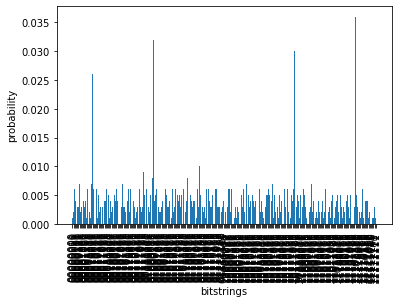

In [21]:
counts = get_result(YOUR_CIRCUIT, n)

In [4]:
from braket.aws import AwsDevice, AwsQuantumTask
# set up device
rigetti = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-1")
rigetti.properties

RigettiDeviceCapabilities(service=DeviceServiceProperties(braketSchemaHeader=BraketSchemaHeader(name='braket.device_schema.device_service_properties', version='1'), executionWindows=[DeviceExecutionWindow(executionDay=<ExecutionDay.EVERYDAY: 'Everyday'>, windowStartHour=datetime.time(15, 0), windowEndHour=datetime.time(20, 0))], shotsRange=(10, 100000), deviceCost=DeviceCost(price=0.00035, unit='shot'), deviceDocumentation=DeviceDocumentation(imageUrl='http://d1.awsstatic.com/logos/Rigetti_logo_rgb_teal.0cbe3c0653e755ab97c04ec56f3611f53e2a780c.png', summary='Universal gate-model QPU based on superconducting qubits', externalDocumentationUrl='https://qcs.rigetti.com/qpus/'), deviceLocation='California, USA', updatedAt=datetime.datetime(2022, 4, 10, 12, 48, 38, tzinfo=datetime.timezone.utc)), action={<DeviceActionType.JAQCD: 'braket.ir.jaqcd.program'>: JaqcdDeviceActionProperties(version=['1.0', '1.1'], actionType='braket.ir.jaqcd.program', supportedOperations=['cz', 'xy', 'ccnot', 'cnot

In [ ]:
# run circuit 
rigetti_task = rigetti.run(YOUR_CIRCUIT, shots=1000)

# get id and status of submitted task
rigetti_task_id = rigetti_task.id
rigetti_status = rigetti_task.state()
# print('ID of task:', rigetti_task_id)
print('Status of task:', rigetti_status)

Let's verify that your quantum job was submitted!

In [ ]:
# print status
!qbraid credits
status = rigetti_task.state()
print('Status of (reconstructed) task:', status)

## Verify your solution
Using our autograder, input the solution you and your teammates have come up with.
Your solution should be a list of integers beginning with the initial node to traverse the graph and ending with the same node to complete the "cycle". 

In [7]:
# feed your solution to the auto-grader in the following format:
from auto_grader import is_hamiltonian_cycle
path = [5,6,1,7,4,2,0,3,5]
is_hamiltonian_cycle(graph,path)

Success: path is a Hamiltonian cycle


True

## References
Grover, L. K. A fast quantum mechanical algorithm for database search. Proceedings of the 28th Annual ACM Symposium on Theory of Computation,212–219 (1996).

Mahasinghe, Anuradha & Hua, Richard & Dinneen, Michael & Goyal, Rajni. (2019). Solving the Hamiltonian Cycle Problem using a Quantum Computer. 1-9. 10.1145/3290688.3290703. 